In [ ]:
!pip install catboost -q
!pip install etna -q

In [2]:
from catboost import CatBoostRegressor

In [23]:
from etna.datasets import TSDataset
from etna.models import SARIMAXModel, HoltWintersModel, TBATSModel, SeasonalMovingAverageModel, CatBoostMultiSegmentModel, CatBoostPerSegmentModel, ProphetModel
from etna.pipeline import Pipeline
from etna.analysis import plot_forecast
from etna.metrics import SMAPE
from etna.transforms import LagTransform, DateFlagsTransform, OneHotEncoderTransform, DensityOutliersTransform
from etna.transforms import TimeSeriesImputerTransform, LinearTrendTransform, TrendTransform, FourierTransform
from etna.transforms import SegmentEncoderTransform, MeanTransform

In [12]:
from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

data = pd.read_excel('/content/Реестр несоответствий.xlsx', sheet_name='owssvr')

data['Дата акта о браке'] = pd.to_datetime(data['Дата акта о браке'])
data = data[['Дата акта о браке']].dropna()

defects_per_day = data.groupby(data['Дата акта о браке'].dt.date).size()

defects_per_day_df = defects_per_day.reset_index()
defects_per_day_df.columns = ['timestamp', 'defects']
defects_per_day_df.set_index('timestamp', inplace=True)

date_range = pd.date_range(start=defects_per_day_df.index.min(), end=defects_per_day_df.index.max())
defects_per_day_df = defects_per_day_df.reindex(date_range, fill_value=0).rename_axis('timestamp').reset_index()

In [13]:
defects_per_day_df['day_of_week'] = defects_per_day_df['timestamp'].dt.dayofweek
defects_per_day_df['month'] = defects_per_day_df['timestamp'].dt.month
defects_per_day_df['day'] = defects_per_day_df['timestamp'].dt.day
defects_per_day_df['year'] = defects_per_day_df['timestamp'].dt.year

In [14]:
ru_holidays = holidays.Russia(years=range(2021, 2024))

holiday_df = pd.DataFrame(list(ru_holidays.items()), columns=['timestamp', 'holiday_name'])
holiday_df['timestamp'] = pd.to_datetime(holiday_df['timestamp'])

In [15]:
added_holidays = pd.DataFrame(holiday_df.iloc[20:39].timestamp.astype(str).apply(lambda x: x[:3] + '4' + x[4:]))
added_holidays['holiday_name'] = holiday_df.iloc[20:39].holiday_name
added_holidays['timestamp'] = pd.to_datetime(added_holidays['timestamp'])
added_holidays

,timestamp,holiday_name
20,2024-01-01,New Year Holidays
21,2024-01-02,New Year Holidays
22,2024-01-03,New Year Holidays
23,2024-01-04,New Year Holidays
24,2024-01-05,New Year Holidays
25,2024-01-06,New Year Holidays
26,2024-01-08,New Year Holidays
27,2024-01-07,Christmas Day
28,2024-02-23,Fatherland Defender's Day
29,2024-03-08,International Women's Day


In [16]:
holiday_df = pd.concat([holiday_df, added_holidays]).reset_index(drop=True)
holiday_df

,timestamp,holiday_name
0,2021-01-01,New Year Holidays
1,2021-01-02,New Year Holidays
2,2021-01-03,New Year Holidays
3,2021-01-04,New Year Holidays
4,2021-01-05,New Year Holidays
...,...,...
70,2024-05-03,Day off (substituted from 01/01/2022)
71,2024-05-10,Day off (substituted from 01/02/2022)
72,2024-03-07,Day off (substituted from 03/05/2022)
73,2024-05-02,Day off (substituted from 05/01/2022)


In [17]:
defects_per_day_df = defects_per_day_df.merge(holiday_df, on='timestamp', how='left')

defects_per_day_df = defects_per_day_df.fillna('-')
defects_per_day_df.holiday_name[defects_per_day_df.holiday_name != '-'] = 1
defects_per_day_df.holiday_name[defects_per_day_df.holiday_name == '-'] = 0

# Catboost

In [18]:
cat_features = ['holiday_name']
X = defects_per_day_df[['timestamp', 'day_of_week', 'month', 'day', 'year', 'holiday_name']].fillna(0)
y = defects_per_day_df['defects']

# X = pd.get_dummies(X, columns=cat_features, drop_first=True)
X['timestamp'] = X['timestamp'].astype(np.int64) // 10**9

train_cutoff = len(X) - 30
X_train, y_train = X[:train_cutoff], y[:train_cutoff]
X_test, y_test = X[train_cutoff:], y[train_cutoff:]

# Model training and prediction
model = CatBoostRegressor(cat_features=cat_features, loss_function='Poisson', iterations=1000, verbose=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

0:	learn: 0.9498335	total: 50.9ms	remaining: 50.8s
999:	learn: 0.1632867	total: 3.97s	remaining: 0us


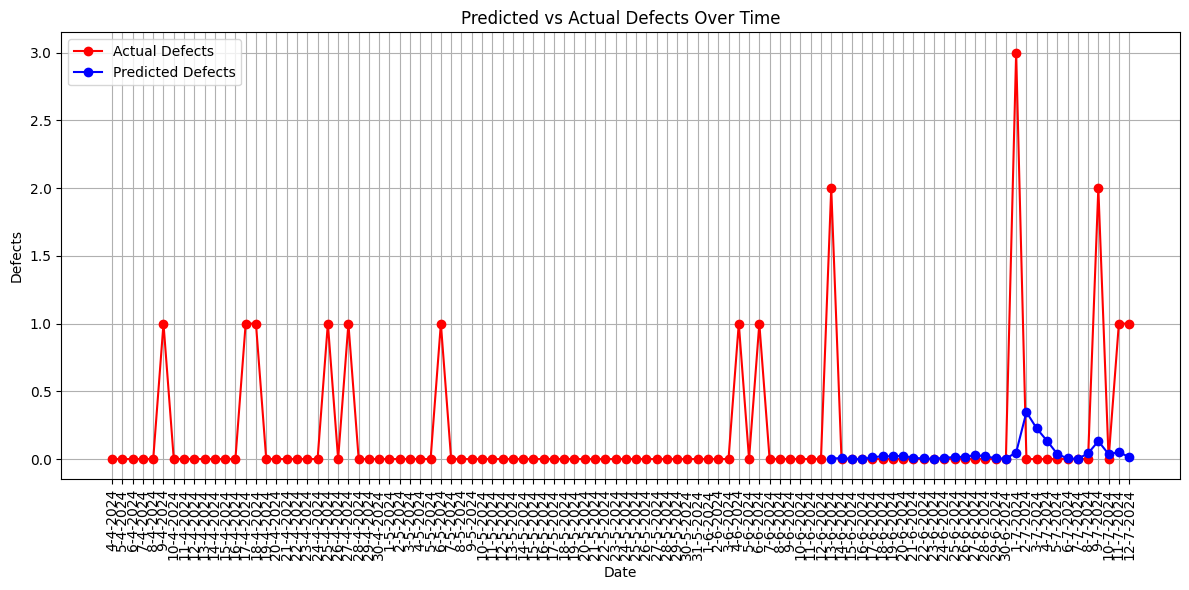

In [19]:
plt.figure(figsize=(12, 6))

plt.plot(X[-100:].apply(lambda x: f'{x.day}-{x.month}-{x.year}', axis=1), y[-100:], marker='o', label='Actual Defects', color='red')

plt.plot(X_test.apply(lambda x: f'{x.day}-{x.month}-{x.year}', axis=1), y_pred, marker='o', label='Predicted Defects', color='blue')

plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Defects')
plt.title('Predicted vs Actual Defects Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#Other models

## Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmte7lz3t/fsf1buk5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmte7lz3t/m2oi7kme.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96317', 'data', 'file=/tmp/tmpmte7lz3t/fsf1buk5.json', 'init=/tmp/tmpmte7lz3t/m2oi7kme.json', 'output', 'file=/tmp/tmpmte7lz3t/prophet_modelgijfkpwc/prophet_model-20241104150436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:04:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:04:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


197.57652415518672


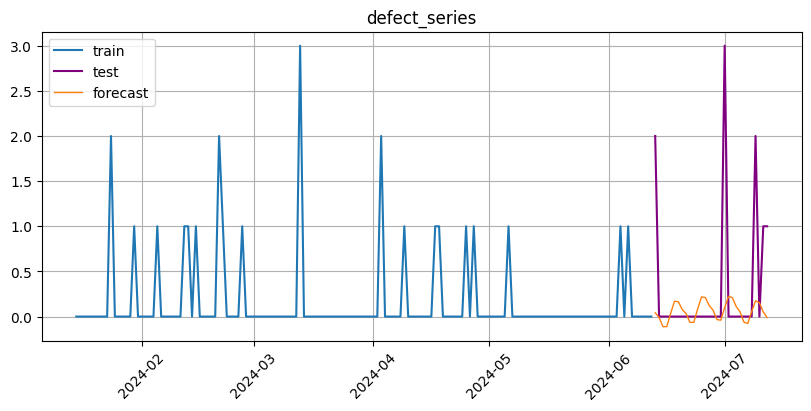

In [98]:
from prophet import Prophet
prophet_df = defects_per_day_df[['timestamp', 'defects']].rename(columns={'timestamp': 'ds', 'defects': 'y'})

prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

train_cutoff = len(prophet_df) - 30
train_df = prophet_df.iloc[:train_cutoff]
test_df = prophet_df.iloc[train_cutoff:]

model = Prophet()
model.fit(train_df)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

forecast_ts = forecast[['ds', 'yhat']].iloc[-30:]
forecast_ts.rename({'ds': 'timestamp', 'yhat': 'target'}, inplace=True, axis=1)
forecast_ts['segment'] = 'defect_series'
forecast_ts = TSDataset(forecast_ts, 'D')

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=150, figsize=(8, 4))

metric_value = metric(y_true=test_ts, y_pred=forecast_ts)
print(metric_value)

## SARIMAX

In [104]:
defects_per_day_df_new = defects_per_day_df.drop(['defects', 'timestamp'], axis=1).fillna(0)
defects_per_day_df_new.head(3)

,day_of_week,month,day,year,holiday_name
0,1,3,9,2021,0
1,2,3,10,2021,0
2,3,3,11,2021,0


In [102]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = defects_per_day_df['defects']

train_cutoff = len(y) - 30
y_train, y_test = y[:train_cutoff], y[train_cutoff:]

model_weekly = SARIMAX(y_train, exog=defects_per_day_df_new[:train_cutoff], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_model_weekly = model_weekly.fit(disp=False)

y_pred_weekly = sarima_model_weekly.get_forecast(exog=defects_per_day_df_new[train_cutoff:], steps=30).predicted_mean

model_monthly = SARIMAX(y_train, exog=defects_per_day_df_new[:train_cutoff], order=(1, 1, 1), seasonal_order=(1, 1, 1, 30))
sarima_model_monthly = model_monthly.fit(disp=False)

y_pred_monthly = sarima_model_monthly.get_forecast(exog=defects_per_day_df_new[train_cutoff:], steps=30).predicted_mean

y_pred_combined = (y_pred_weekly + y_pred_monthly) / 2

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


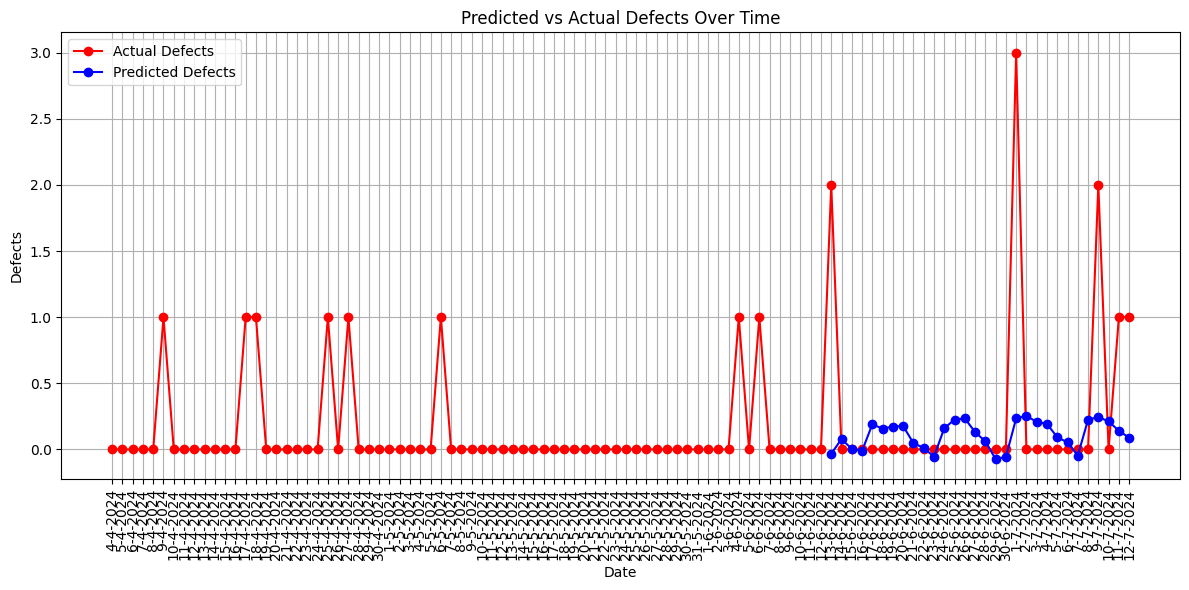

In [103]:
plt.figure(figsize=(12, 6))

plt.plot(X[-100:].apply(lambda x: f'{x.day}-{x.month}-{x.year}', axis=1), y[-100:], marker='o', label='Actual Defects', color='red')

plt.plot(X_test.apply(lambda x: f'{x.day}-{x.month}-{x.year}', axis=1), y_pred_combined, marker='o', label='Predicted Defects', color='blue')

plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Defects')
plt.title('Predicted vs Actual Defects Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## HistGradientBoostingRegressor

In [109]:
X = defects_per_day_df[['day_of_week', 'month', 'day', 'year', 'holiday_name']]
y = defects_per_day_df['defects']

train_cutoff = len(X) - 30
X_train, y_train = X[:train_cutoff], y[:train_cutoff]
X_test, y_test = X[train_cutoff:], y[train_cutoff:]

model = HistGradientBoostingRegressor(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

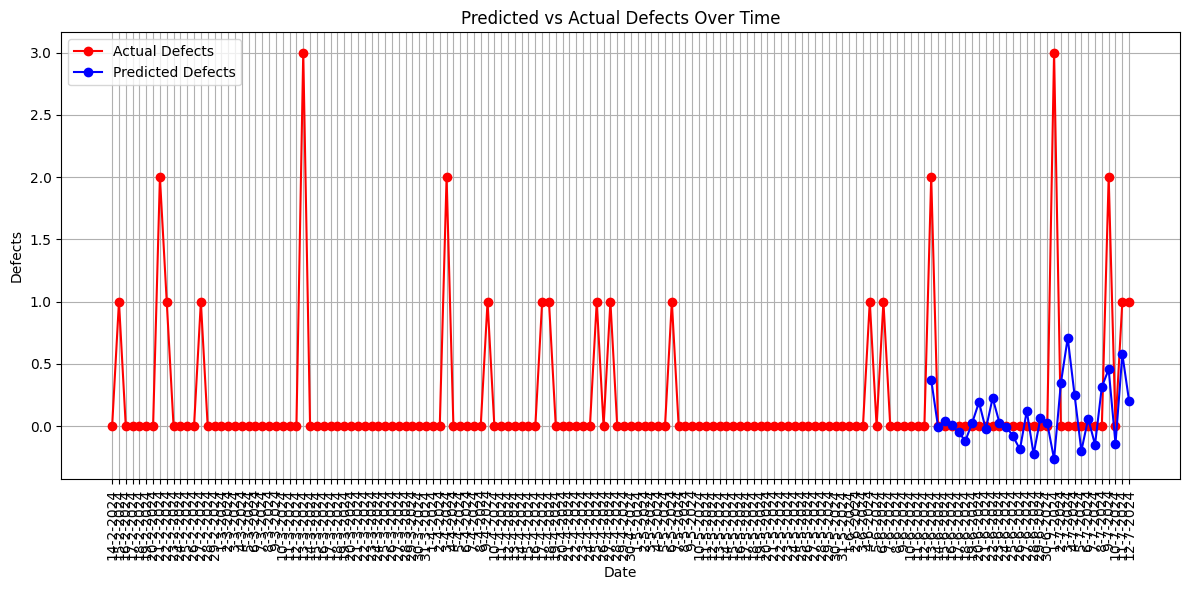

In [110]:
plt.figure(figsize=(12, 6))

plt.plot(X[-150:].apply(lambda x: f'{x.day}-{x.month}-{x.year}', axis=1), y[-150:], marker='o', label='Actual Defects', color='red')

plt.plot(X_test.apply(lambda x: f'{x.day}-{x.month}-{x.year}', axis=1), y_pred, marker='o', label='Predicted Defects', color='blue')

plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Defects')
plt.title('Predicted vs Actual Defects Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Etna

## preprocessing

In [82]:
HORIZON = 30

transforms = [
    DensityOutliersTransform(in_column="target", distance_coef=3.0),
    TimeSeriesImputerTransform(in_column="target", strategy="forward_fill"),
    LinearTrendTransform(in_column="target"),
    TrendTransform(in_column="target", out_column="trend_"),
    # LagTransform(in_column="target", lags=[7, 14, 30], out_column="target_lag"),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        week_number_in_month=True,
        month_number_in_year=True,
        season_number=True,
        is_weekend=True,
    ),
    FourierTransform(period=360.25, order=6, out_column="fourier"),
    # MeanTransform(in_column=f"target_lag_{HORIZON}", window=12, seasonality=7),
    # MeanTransform(in_column=f"target_lag_{HORIZON}", window=7),
]

In [79]:
df = defects_per_day_df.rename(columns={'defects': 'target'})
df['segment'] = 'defect_series'

ts = TSDataset(df, 'D')
train_ts_base, test_ts_base = ts.train_test_split(test_size=HORIZON)
metric = SMAPE(mode="macro")

## SeasonalMovingAverageModel

/usr/local/lib/python3.10/dist-packages/etna/models/seasonal_ma.py:64: UserWarning: This model doesn't work with exogenous features. Columns {'day', 'fourier_7', "MeanTransform(in_column = 'target_lag_30', window = 12, seasonality = 7, alpha = 1, min_periods = 1, fillna = 0, out_column = None, )", "MeanTransform(in_column = 'target_lag_30', window = 7, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, )", 'fourier_8', 'fourier_6', 'DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, in_column = None, )', 'segment_code', 'day_of_week', 'fourier_11', 'trend', 'month', 'fourier_9', 'year', 'DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = Fals

192.94759656249656


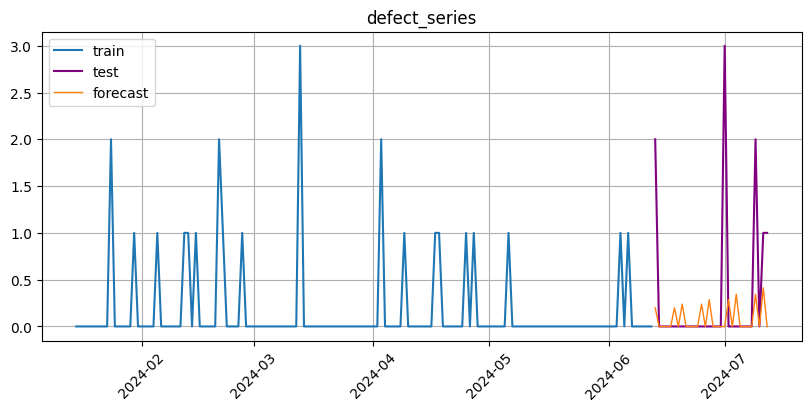

In [35]:
model = SeasonalMovingAverageModel()

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
pipeline.fit(train_ts)

forecast_ts = pipeline.forecast()

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=train_ts, n_train_samples=150, figsize=(8, 4))

metric_value = metric(y_true=test_ts, y_pred=forecast_ts)
print(metric_value)

## ProphetModel

/usr/local/lib/python3.10/dist-packages/etna/models/prophet.py:111: UserWarning: This model doesn't work with exogenous features unknown in future. Columns ['day', 'day_of_week', 'holiday_name', 'month', 'year'] won't be used.
  warnings.warn(
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmte7lz3t/z9qqz3f0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmte7lz3t/jgivoafz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75561', 'data', 'file=/tmp/tmpmte7lz3t/z9qqz3f0.json', 'init=/tmp/tmpmte7lz3t/jgivoafz.json', 'output', 'file=/tmp/tmpmte7lz3t/prophet_modelpv0ux_i0/prophet_model-20241104144511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:45:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start proces

198.844378594728


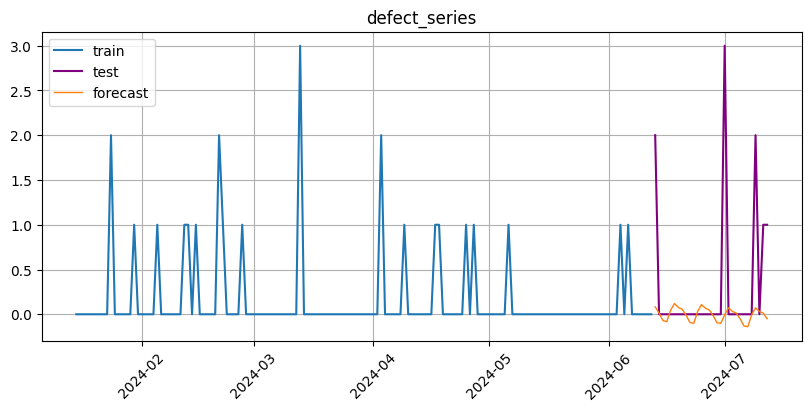

In [83]:
model = ProphetModel()

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

train_ts = deepcopy(train_ts_base)
pipeline.fit(train_ts)

forecast_ts = pipeline.forecast()

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts_base, train_ts=train_ts_base, n_train_samples=150, figsize=(8, 4))

metric_value = metric(y_true=test_ts_base, y_pred=forecast_ts)
print(metric_value)

## SARIMAXModel

/usr/local/lib/python3.10/dist-packages/etna/models/sarimax.py:182: UserWarning: This model doesn't work with exogenous features unknown in future. Columns ['day', 'day_of_week', 'holiday_name', 'month', 'year'] won't be used.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


197.8434097807287


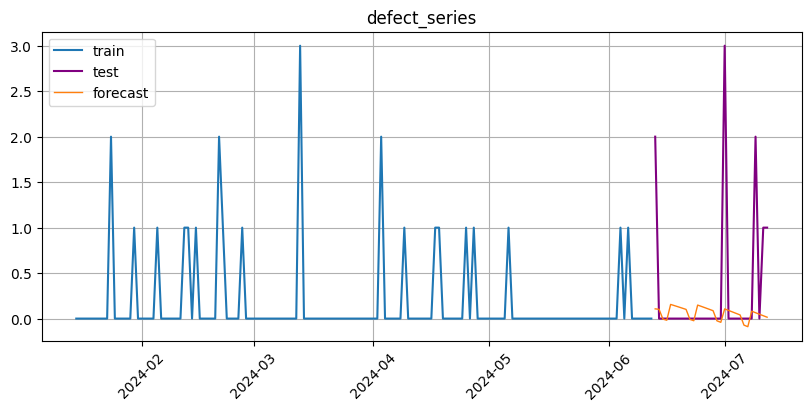

In [84]:
model = SARIMAXModel()

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

train_ts = deepcopy(train_ts_base)
pipeline.fit(train_ts)

forecast_ts = pipeline.forecast()

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts_base, train_ts=train_ts_base, n_train_samples=150, figsize=(8, 4))

metric_value = metric(y_true=test_ts_base, y_pred=forecast_ts)
print(metric_value)

## CatBoostMultiSegmentModel

196.52433147779846


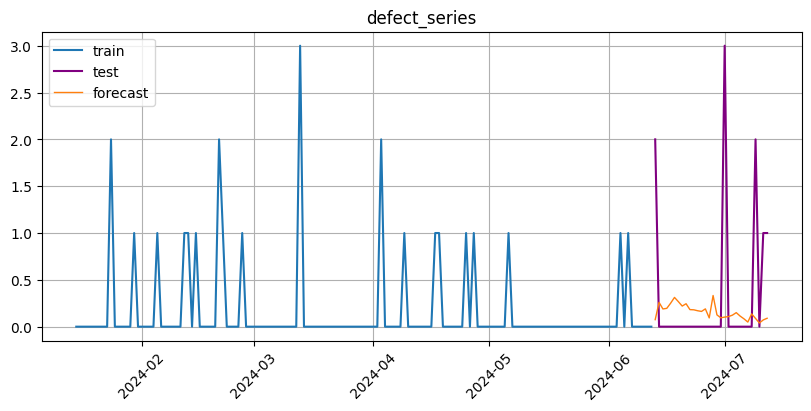

In [74]:
model = CatBoostMultiSegmentModel()

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

train_ts = deepcopy(train_ts_base)
pipeline.fit(train_ts)

forecast_ts = pipeline.forecast()

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts_base, train_ts=train_ts_base, n_train_samples=150, figsize=(8, 4))

metric_value = metric(y_true=test_ts_base, y_pred=forecast_ts)
print(metric_value)

## CatBoostPerSegmentModel

197.52113535185435


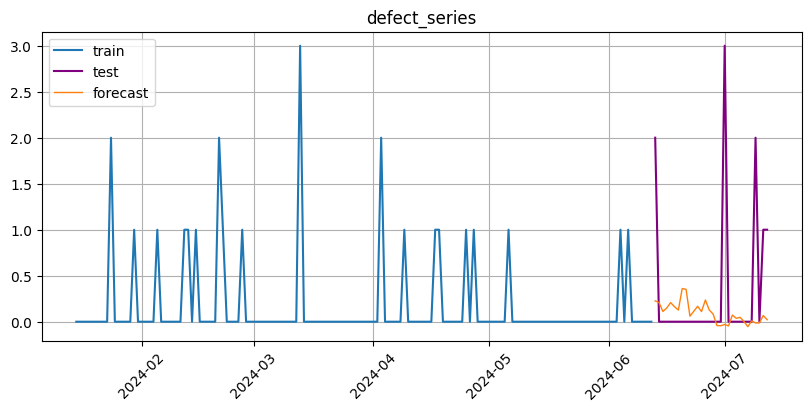

In [86]:
model = CatBoostPerSegmentModel()

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

train_ts = deepcopy(train_ts_base)
pipeline.fit(train_ts)

forecast_ts = pipeline.forecast()

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts_base, train_ts=train_ts_base, n_train_samples=150, figsize=(8, 4))

metric_value = metric(y_true=test_ts_base, y_pred=forecast_ts)
print(metric_value)

## TBATSModel

/usr/local/lib/python3.10/dist-packages/etna/models/tbats.py:39: UserWarning: This model doesn't work with exogenous features. Columns {'day', 'fourier_7', 'fourier_8', 'fourier_6', 'DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, in_column = None, )', 'day_of_week', 'fourier_11', 'month', 'fourier_9', 'year', 'DateFlagsTransform(day_number_in_week = False, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = True, season_number = False, year_number = False, is_weekend = False, special_days_in_week = (), special_days_in_month = (), out_column = None, in_column = None, )', 'fourier_2', 'DateFlagsTransform(day_number_in_week =

197.39290373037358


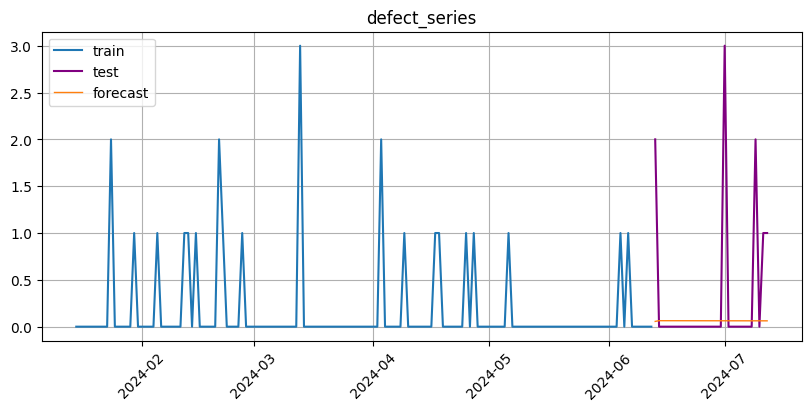

In [85]:
model = TBATSModel()

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

train_ts = deepcopy(train_ts_base)
pipeline.fit(train_ts)

forecast_ts = pipeline.forecast()

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts_base, train_ts=train_ts_base, n_train_samples=150, figsize=(8, 4))

metric_value = metric(y_true=test_ts_base, y_pred=forecast_ts)
print(metric_value)